In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

### read decays

In [2]:
#auxilary functions to preprocess decay data
import pandas as pd
def decayQuality(decayString):
    '''how orthodoxal KS is [lower = better]'''
    particle_codes = decayString.split('&')
    piplus_count = particle_codes.count('211')
    piminus_count = particle_codes.count('-211')
    
    if piplus_count ==0 and piminus_count ==0: return float('inf')
    
    return len(particle_codes) - piplus_count - piminus_count
def preprocess_decay_data(df_path,
                          min_decay_z = -500000,
                          max_quality = 3000,
                          max_origin_distance=500000,
                          min_flight_distance = -1000,
                          ):
    """load KS decay dataframe generated by /preprocess/KS_extractor.py 
    and filter out irrelevant decays (e.g. Ks->2pi0)"""
    
    print "reading",df_path

    
    decay_df = pd.DataFrame.from_csv(df_path,index_col=None,sep=';')
    decay_df.children = decay_df.children.astype(np.string_)

    print len(np.unique( (decay_df.runID,decay_df.eventID))),'events in dataframe'


    decay_df["originDistanceZ"] = (decay_df.originZ - decay_df.primaryZ)
    
    decay_df["decayQuality"] = map(decayQuality,decay_df.children)
    
    decay_vectors = decay_df[["decayX","decayY","decayZ"]].values
    origin_vectors = decay_df[["originX","originY","originZ"]].values
    decay_df["flightDistance"] = np.linalg.norm(decay_vectors-origin_vectors,axis=1)
    
    
    isGood = np.logical_and.reduce([
        decay_df.decayQuality <=max_quality,
        decay_df.originDistanceZ.abs() <= max_origin_distance,
        decay_df.flightDistance >= min_flight_distance,
        decay_df.decayZ >= min_decay_z
    ])
    good_decay_df = decay_df[isGood]
    print len(np.unique( (good_decay_df.runID,good_decay_df.eventID))),'events left with relevant decays'
    return good_decay_df

In [3]:
decay_df_paths = ["/mnt/KSfinder/mc_sig/KS_decays_5.csv","/mnt/KSfinder/mc_sig/KS_decays_6.csv"]

decay_dataframe_shards = map(preprocess_decay_data,decay_df_paths)

decays = pd.concat(decay_dataframe_shards)

print len(decays),'relevant decays total in all dataframes'
print 'grouping...'

#function (runID(int),eventID(int)) -> decays for this pair(df)
decay_groups = decays.groupby(["runID","eventID"],as_index=True)

#strip unused columns
decay_groups = decay_groups[[u'decayX',u'decayY',u'decayZ',u'children',u'flightDistance']]

#e.g. decay_groups.get_group((3695761 ,485762))
print 'done'

reading /mnt/KSfinder/mc_sig/KS_decays_5.csv
17573 events in dataframe
17571 events left with relevant decays
reading /mnt/KSfinder/mc_sig/KS_decays_6.csv
17573 events in dataframe
17571 events left with relevant decays
457632 relevant decays total in all dataframes
grouping...
done


<matplotlib.colorbar.Colorbar instance at 0x7f258cf66cb0>

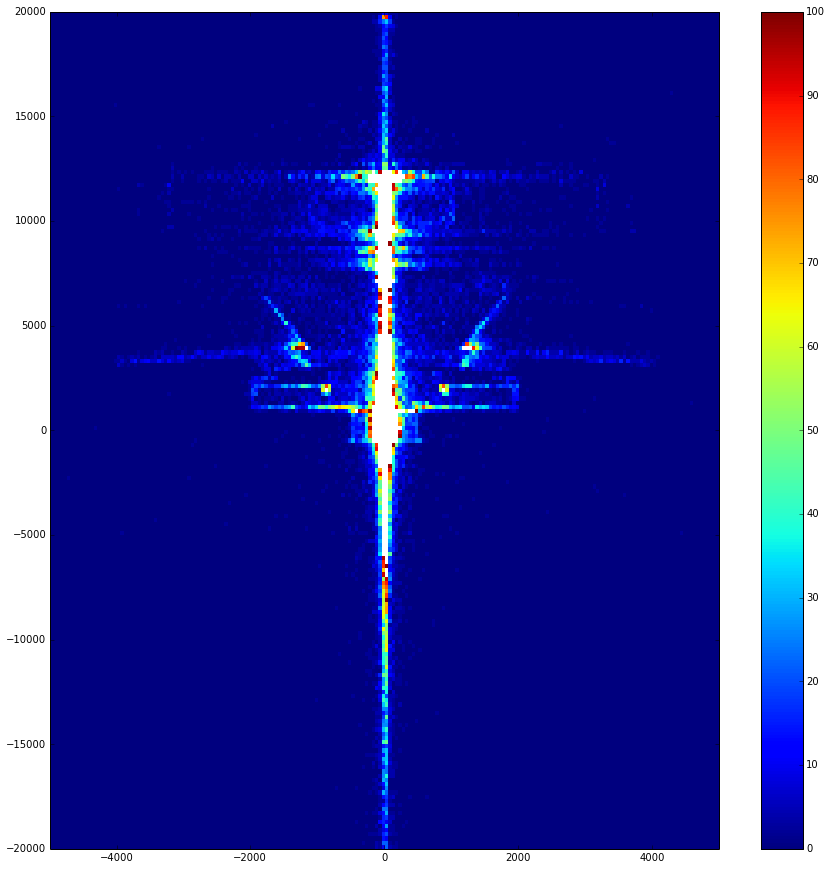

In [12]:
#sanity check: decay vertex heatmap
plt.figure(figsize=[15,15])
_= plt.hist2d(decays.decayY.values,decays.originZ.values,
             bins = [200,200],cmax = 100,range=[[-5000,5000],[-20000,20000]])
plt.colorbar()

In [5]:
from retina.percentile_grid import PercentileSpaceMapper1D

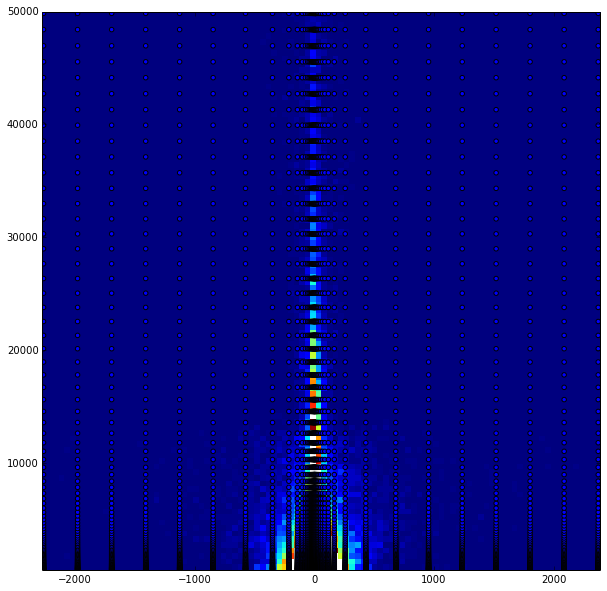

In [6]:
plt.figure(figsize=[10,10])
xmapper = PercentileSpaceMapper1D(decays.decayX,n_centers=50,sigma=3.)
ymapper = PercentileSpaceMapper1D(decays.decayY,n_centers=50,sigma=3.)
zmapper = PercentileSpaceMapper1D(decays.decayZ,n_centers=100,sigma = 1.5)



from itertools import product
plt.scatter(*zip(*product(xmapper.centers,zmapper.centers)))
_= plt.hist2d(decays.decayX.values,decays.decayZ.values,
             bins = [100,100],cmax = 100)



--------------------
actual points: [  9.8355 -74.054   17.7203 -29.7995  -8.419    7.8716]
6 decays
21 active receptors


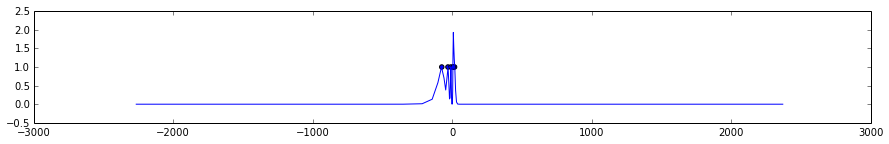

--------------------
actual points: [-186.7991   10.5899   30.0815]
3 decays
13 active receptors


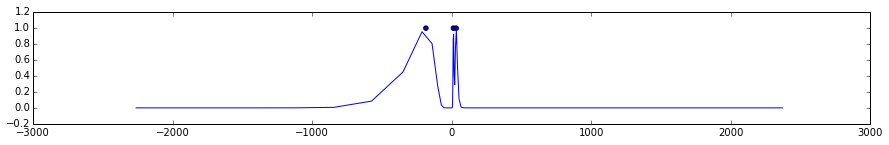

--------------------
actual points: [ 38.591]
1 decays
5 active receptors


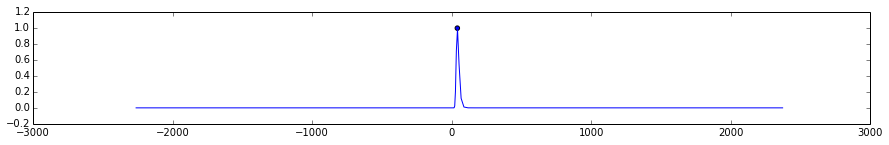

--------------------
actual points: [-11.3411 -12.1411 -95.3244]
3 decays
10 active receptors


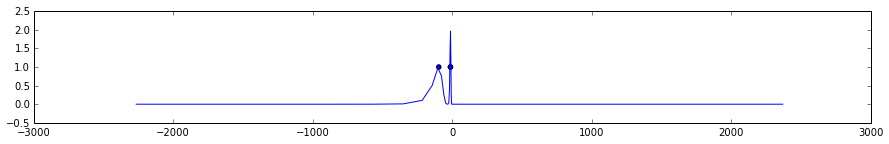

--------------------
actual points: [ 58.5563 -17.3684  19.3653]
3 decays
13 active receptors


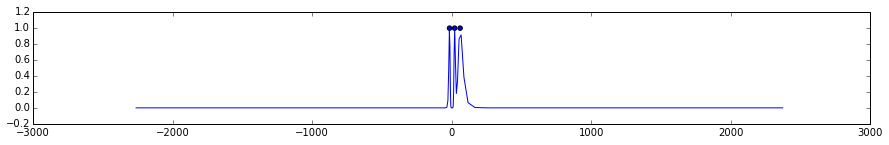

--------------------
actual points: [-41.8893]
1 decays
4 active receptors


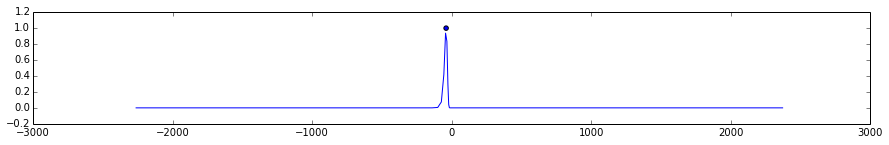

--------------------
actual points: [ 26.3853]
1 decays
5 active receptors


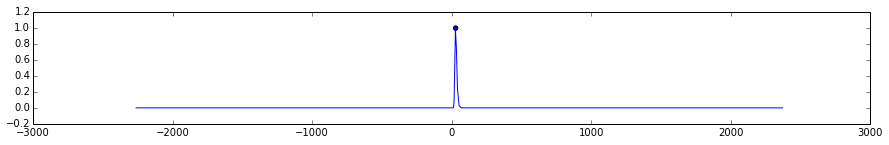

--------------------
actual points: [ 48.0964]
1 decays
5 active receptors


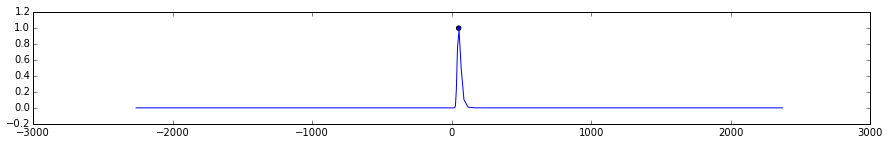

--------------------
actual points: [ 34.8441]
1 decays
4 active receptors


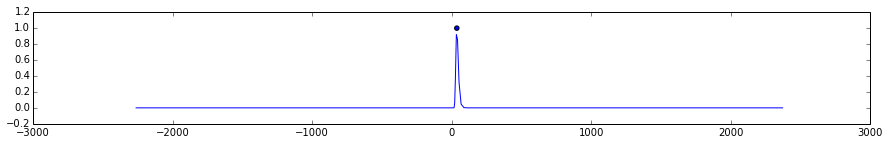

--------------------
actual points: [  12.8437  -23.9314 -108.8594   -1.3342]
4 decays
18 active receptors


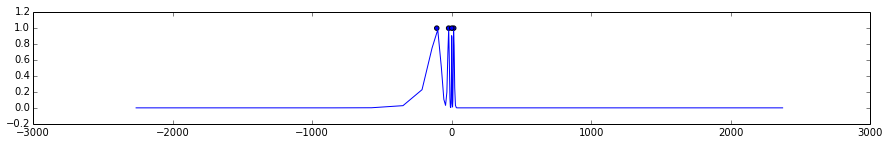

In [9]:
import random
for i in range(10):
    evt = random.choice(decay_groups.groups.keys())
    evt_decays = decay_groups.get_group(evt)

    points = evt_decays.decayX.values
    mapper = xmapper

    activation = mapper.get_activity_percentile(points)
    print '-'*20
    print 'actual points:',points
    print len(evt_decays),'decays'
    print sum(activation>0.1),'active receptors'
    plt.figure(figsize=[15,2])
    plt.plot(mapper.centers,activation)
    #plt.plot(mapper.centers,activation>0.1)
    
    #plt.xticks(range(0,len(centers),10),centers[::10])
    #plt.plot(activation)
    #plt.plot(activation>0.1)
    
    plt.scatter(points,np.ones_like(points))
    
    plt.show()

--------------------
actual points: [ 11074.3841   1428.5648]
2 decays
9 active receptors


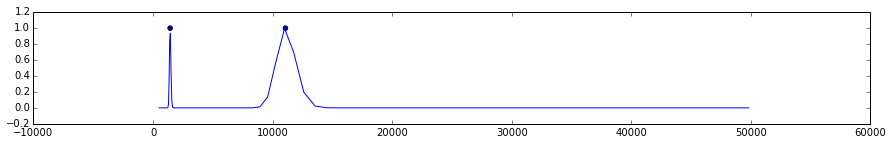

--------------------
actual points: [  1248.8397  10872.1714]
2 decays
10 active receptors


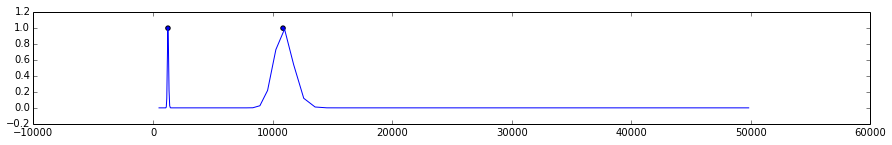

--------------------
actual points: [  637.4162  2074.6318]
2 decays
9 active receptors


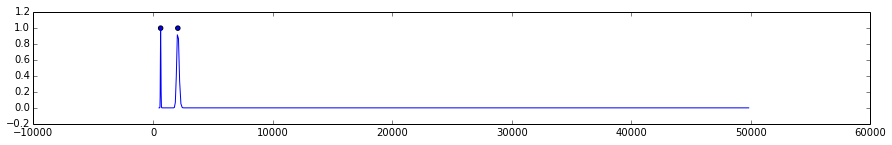

--------------------
actual points: [ 10625.6643   3440.5398]
2 decays
8 active receptors


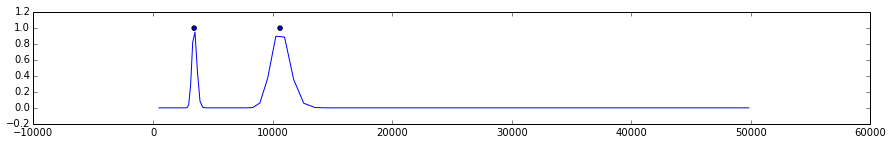

--------------------
actual points: [ 2185.9716  3746.932 ]
2 decays
9 active receptors


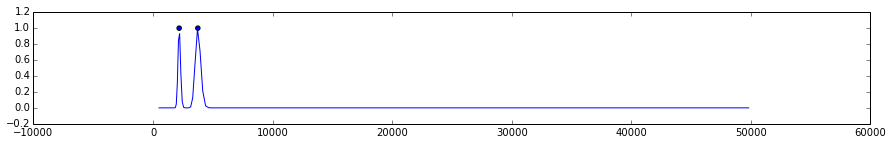

--------------------
actual points: [ 5398.5784  2147.3342]
2 decays
9 active receptors


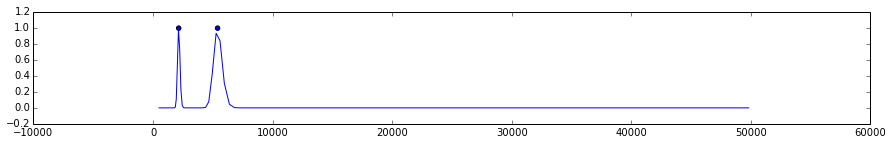

--------------------
actual points: [  1559.7428  16971.6076]
2 decays
9 active receptors


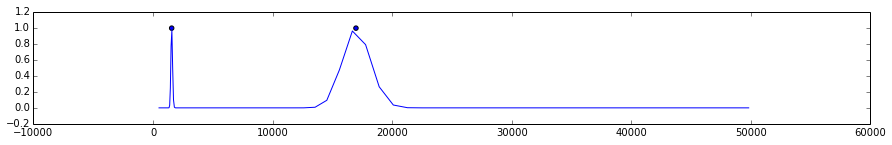

--------------------
actual points: [ 1101.8267]
1 decays
5 active receptors


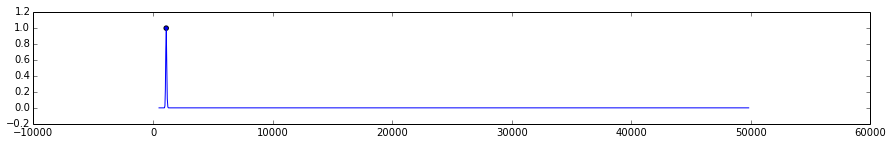

--------------------
actual points: [ 1004.967   1359.8256]
2 decays
9 active receptors


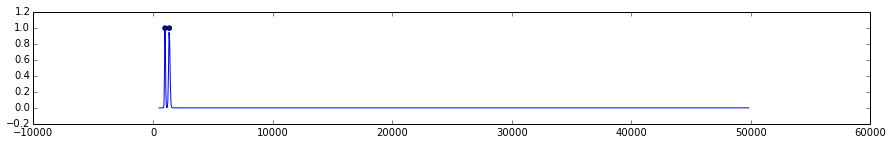

--------------------
actual points: [ 1544.5013  1140.7495]
2 decays
9 active receptors


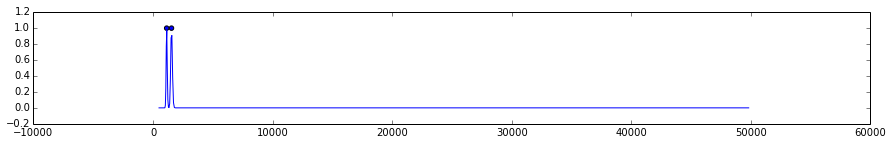

In [12]:
import random
for i in range(10):
    evt = random.choice(decay_groups.groups.keys())
    evt_decays = decay_groups.get_group(evt)

    points = evt_decays.decayZ.values
    mapper = zmapper

    activation = mapper.get_activity_percentile(points)
    print '-'*20
    print 'actual points:',points
    print len(evt_decays),'decays'
    print sum(activation>0.1),'active receptors'
    plt.figure(figsize=[15,2])
    plt.plot(mapper.centers,activation)
    #plt.plot(mapper.centers,activation>0.1)
    
    #plt.xticks(range(0,len(centers),10),centers[::10])
    #plt.plot(activation)
    #plt.plot(activation>0.1)
    
    plt.scatter(points,np.ones_like(points))
    
    plt.show()

--------------------
actual points: [ 27.337]
1 decays
5 active receptors


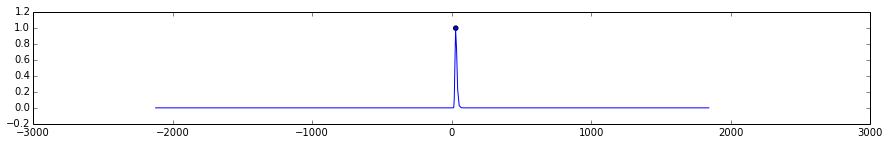

--------------------
actual points: [ 22.0413  -5.6409]
2 decays
8 active receptors


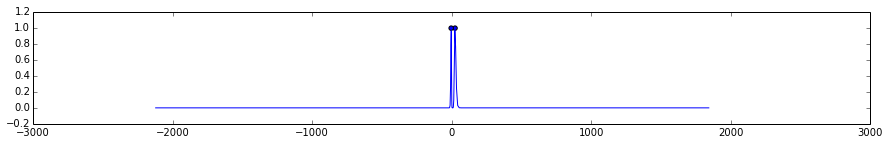

--------------------
actual points: [ 15.3226 -19.4083]
2 decays
8 active receptors


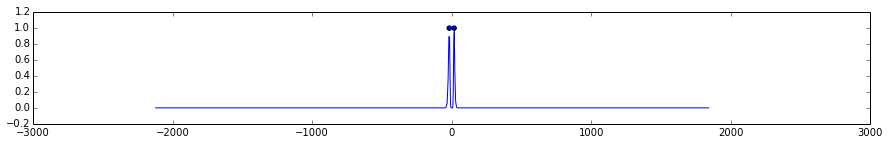

--------------------
actual points: [-11.5627   1.5798 -10.3025  -9.4228]
4 decays
10 active receptors


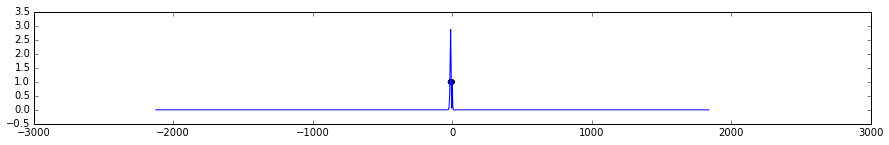

--------------------
actual points: [  33.4539   42.5069 -116.2402]
3 decays
10 active receptors


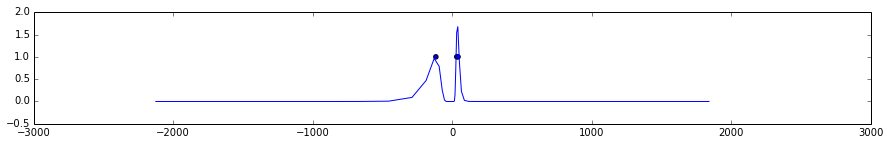

--------------------
actual points: [  -1.6546 -120.7926   30.7017   -8.5932]
4 decays
17 active receptors


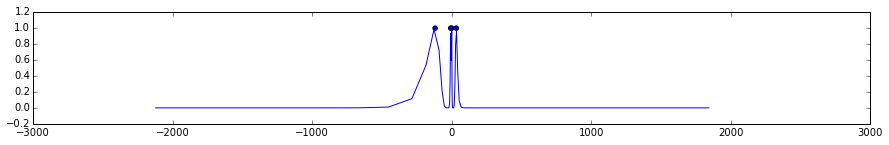

--------------------
actual points: [-16.1145]
1 decays
4 active receptors


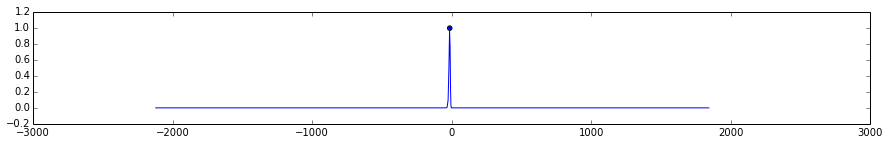

--------------------
actual points: [ 64.9506]
1 decays
5 active receptors


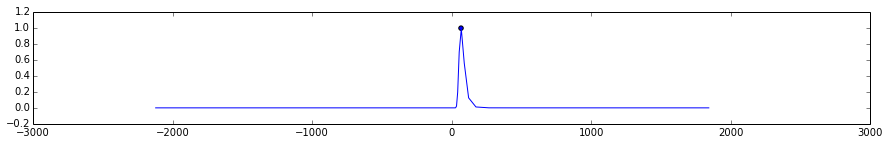

--------------------
actual points: [  1.2305 -33.4591  -3.8918]
3 decays
13 active receptors


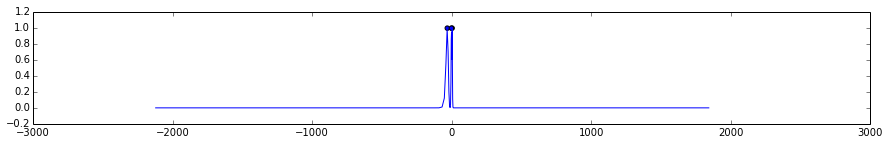

--------------------
actual points: [ 38.6963]
1 decays
4 active receptors


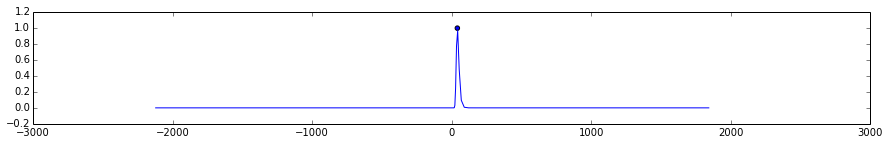

In [11]:
import random
for i in range(10):
    evt = random.choice(decay_groups.groups.keys())
    evt_decays = decay_groups.get_group(evt)

    points = evt_decays.decayY.values
    mapper = ymapper

    activation = mapper.get_activity_percentile(points)
    print '-'*20
    print 'actual points:',points
    print len(evt_decays),'decays'
    print sum(activation>0.1),'active receptors'
    plt.figure(figsize=[15,2])
    plt.plot(mapper.centers,activation)
    #plt.plot(mapper.centers,activation>0.1)
    
    #plt.xticks(range(0,len(centers),10),centers[::10])
    #plt.plot(activation)
    #plt.plot(activation>0.1)
    
    plt.scatter(points,np.ones_like(points))
    
    plt.show()